In [9]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Read data
path = '/Users/mouyasushi/Desktop/Machine Learning /skl_cs/crypto/Alpha-Research/ML/agg_data.parquet'
df = pq.read_table(path).to_pandas()
print(f"Dataset shape: {df.shape}")

# Data preprocessing (same as HW1.ipynb)
df = df.dropna(subset=['daily_return'])
df['open_time'] = pd.to_datetime(df['open_time'])

feature_cols = ['open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume',
       'volatility_7d', 'volatility_14d', 'volatility_30d', 'typical_price',
       'tp_vol', 'vwap_7d', 'vwap_14d', 'vwap_30d', 'vwap_7d_diff',
       'vwap_14d_diff', 'vwap_30d_diff', 'vwap_7d_trend',
       'vwap_7d_trend_direction', 'vwap_14d_trend', 'vwap_14d_trend_direction',
       'vwap_30d_trend', 'vwap_30d_trend_direction', 'rsi_7', 'rsi_14',
       'rsi_21', 'ema_7', 'ema_14', 'ema_30', 'ema_90', 'atr_7', 'atr_14',
       'atr_21', 'macd_line', 'macd_signal', 'macd_histogram', 'alpha1']

target_col = 'daily_return'

# Handle missing values
missing_values = df[feature_cols + [target_col]].isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values:")
    print(missing_values[missing_values > 0])
    df = df.dropna(subset=feature_cols + [target_col])

print(f"Dataset size after handling missing values: {len(df)}")

# Handle categorical variables
trend_mapping = {
    'Up': 1,
    'Down': 0,
}

# Map 'Up'/'Down' columns to numerical values
df['vwap_7d_trend_direction'] = df['vwap_7d_trend_direction'].map(trend_mapping)
df['vwap_14d_trend_direction'] = df['vwap_14d_trend_direction'].map(trend_mapping)
df['vwap_30d_trend_direction'] = df['vwap_30d_trend_direction'].map(trend_mapping)

# Split training and testing sets
cutoff_date = df['open_time'].sort_values().iloc[-int(len(df)/10)]  # Use the last 10% of data as test set
train_data = df[df['open_time'] <= cutoff_date]
test_data = df[df['open_time'] > cutoff_date]

print(f"\nTraining set shape: {train_data.shape}")
print(f"Testing set shape: {test_data.shape}")
print(f"Training set date range: {train_data['open_time'].min()} to {train_data['open_time'].max()}")
print(f"Testing set date range: {test_data['open_time'].min()} to {test_data['open_time'].max()}")



Dataset shape: (31878, 44)

Missing values:
volatility_7d     126
volatility_14d    273
volatility_30d    609
vwap_7d           105
vwap_14d          252
vwap_30d          588
vwap_7d_diff      105
vwap_14d_diff     252
vwap_30d_diff     588
vwap_7d_trend     126
vwap_14d_trend    273
vwap_30d_trend    609
rsi_7             105
rsi_14            252
rsi_21            399
ema_7             105
ema_14            252
ema_30            588
atr_7             105
atr_14            252
atr_21            399
alpha1            546
dtype: int64
Dataset size after handling missing values: 31248

Training set shape: (28140, 44)
Testing set shape: (3108, 44)
Training set date range: 2021-01-31 00:00:00 to 2024-10-01 00:00:00
Testing set date range: 2024-10-02 00:00:00 to 2025-02-26 00:00:00


In [10]:
# Extract features and target variables
X_train = train_data[feature_cols].values
y_train = train_data[target_col].values
X_test = test_data[feature_cols].values
y_test = test_data[target_col].values


In [11]:
# use Std Scalar to de-mean, however we didn't divide std 
scaler = StandardScaler(with_std= False)  # without dividing std 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Get number of features
p = X_train.shape[1]
print(f"Number of features: {p}")

Number of features: 40


In [13]:
# Store RMSE for each K value for training and testing sets
train_rmse = []
test_rmse = []

# Perform PCR for each K value from 1 to P
for k in range(1, p + 1):
    # 1. Use PCA for dimensionality reduction
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # 2. Train linear regression model with reduced features
    pcr_model = LinearRegression()
    pcr_model.fit(X_train_pca, y_train)
    
    # 3. Predict on training set and calculate RMSE
    y_train_pred = pcr_model.predict(X_train_pca)
    rmse_train_k = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_rmse.append(rmse_train_k)
    
    # 4. Predict on testing set and calculate RMSE
    y_test_pred = pcr_model.predict(X_test_pca)
    rmse_test_k = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_rmse.append(rmse_test_k)
    
    print(f"K = {k}, Training RMSE = {rmse_train_k:.6f}, Testing RMSE = {rmse_test_k:.6f}")



K = 1, Training RMSE = 0.053981, Testing RMSE = 0.056762
K = 2, Training RMSE = 0.053760, Testing RMSE = 0.056290
K = 3, Training RMSE = 0.052325, Testing RMSE = 0.054957
K = 4, Training RMSE = 0.052008, Testing RMSE = 0.053959
K = 5, Training RMSE = 0.051660, Testing RMSE = 0.053397
K = 6, Training RMSE = 0.051589, Testing RMSE = 0.053059
K = 7, Training RMSE = 0.051585, Testing RMSE = 0.053051
K = 8, Training RMSE = 0.051551, Testing RMSE = 0.053032
K = 9, Training RMSE = 0.051541, Testing RMSE = 0.053024
K = 10, Training RMSE = 0.051540, Testing RMSE = 0.053034
K = 11, Training RMSE = 0.051540, Testing RMSE = 0.053029
K = 12, Training RMSE = 0.051539, Testing RMSE = 0.053016
K = 13, Training RMSE = 0.051534, Testing RMSE = 0.053000
K = 14, Training RMSE = 0.051531, Testing RMSE = 0.053008
K = 15, Training RMSE = 0.051529, Testing RMSE = 0.053020
K = 16, Training RMSE = 0.051529, Testing RMSE = 0.053019
K = 17, Training RMSE = 0.051528, Testing RMSE = 0.053023
K = 18, Training RMSE =

Q2 


K value with minimum training RMSE: 39, RMSE = 0.038307
K value with minimum testing RMSE: 40, RMSE = 0.038479


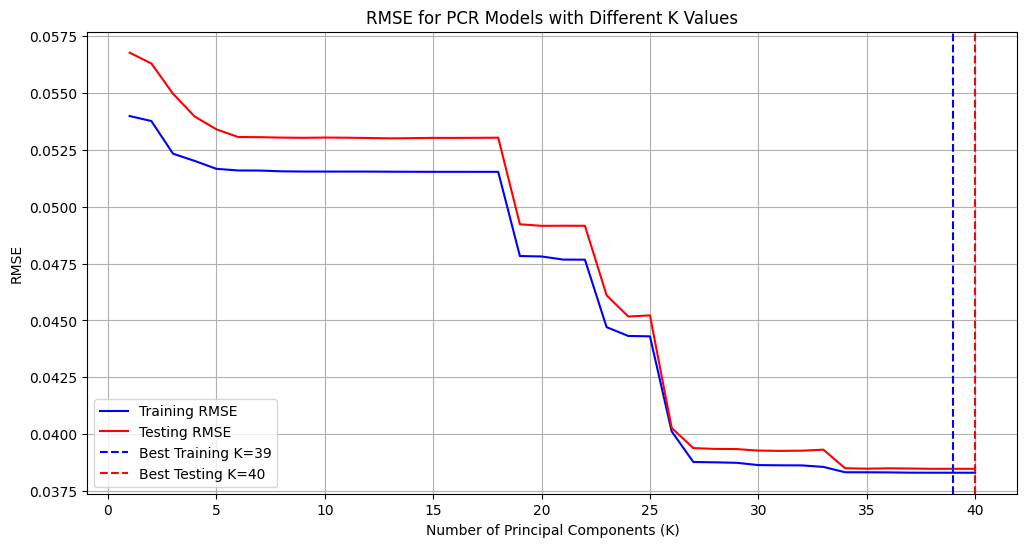

In [14]:
# Find K values with minimum RMSE for training and testing sets
min_train_rmse_idx = np.argmin(train_rmse)
min_test_rmse_idx = np.argmin(test_rmse)

print(f"\nK value with minimum training RMSE: {min_train_rmse_idx + 1}, RMSE = {train_rmse[min_train_rmse_idx]:.6f}")
print(f"K value with minimum testing RMSE: {min_test_rmse_idx + 1}, RMSE = {test_rmse[min_test_rmse_idx]:.6f}")

# Visualize RMSE for different K values
plt.figure(figsize=(12, 6))
plt.plot(range(1, p + 1), train_rmse, 'b-', label='Training RMSE')
plt.plot(range(1, p + 1), test_rmse, 'r-', label='Testing RMSE')
plt.axvline(x=min_train_rmse_idx + 1, color='b', linestyle='--', label=f'Best Training K={min_train_rmse_idx + 1}')
plt.axvline(x=min_test_rmse_idx + 1, color='r', linestyle='--', label=f'Best Testing K={min_test_rmse_idx + 1}')
plt.xlabel('Number of Principal Components (K)')
plt.ylabel('RMSE')
plt.title('RMSE for PCR Models with Different K Values')
plt.legend()
plt.grid(True)
plt.show()

